In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using Plots, QuadGK
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [3]:
using ChainRulesCore: ignore_derivatives

In [4]:
using Base: @kwdef

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
size(q)

(20, 13, 21, 99991)

In [12]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [13]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [14]:
q |> size

(20, 13, 21, 99991)

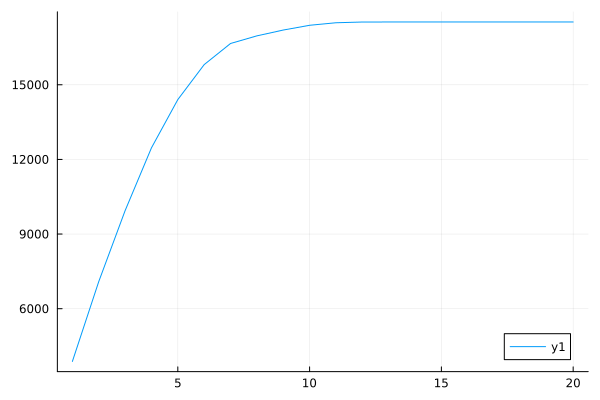

In [15]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

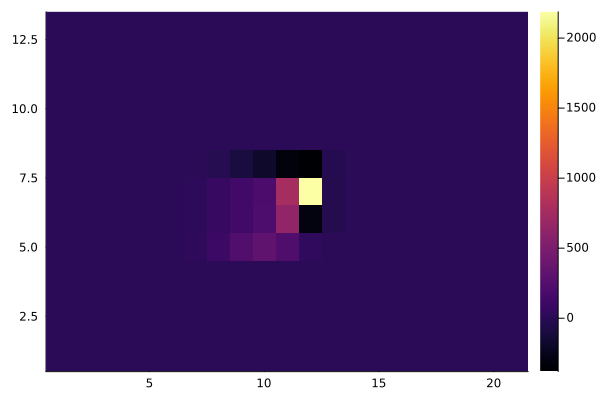

In [16]:
heatmap(q[1,:,:,128])

In [17]:
ylocal |> size

(99991,)

In [18]:
phase_to_current

phase_to_current (generic function with 1 method)

In [19]:
pt |> size

(99991,)

In [20]:
train_loader = DataLoader((q, ylocal, pt), partial = false, batchsize=args.batchsize)

781-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [21]:
using Base.Iterators: take

In [22]:
s1, s2 = take(train_loader, 2) |> collect

2-element Vector{Any}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0

In [23]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), partial = false, batchsize=args.batchsize)

390-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [24]:
x, xl, y = s1

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [25]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [26]:
x |> size

(20, 13, 21, 128)

In [27]:
n_px = size(x, 2) 
n_in = n_px + 1

14

In [28]:
spk_args = SpikingArgs(leakage=-0.1)
tspan = (0.0, 20.0)

(0.0, 20.0)

# Set up the model

In [36]:
x_tms = range(start=0.0, stop=1.0, length=size(x,1)) |> collect;

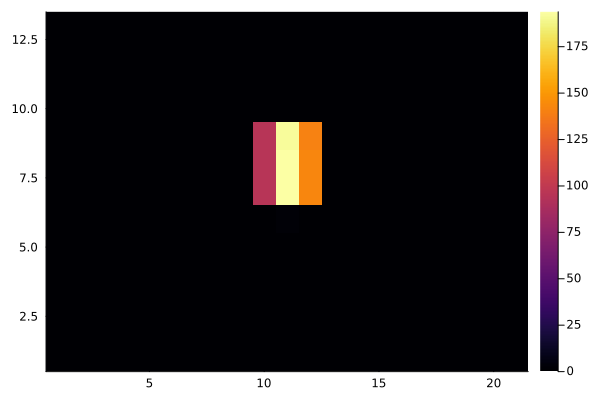

In [37]:
heatmap(interpolate_2D_derivative(0.5, x_tms, x)[:,:,1])

In [38]:
xi = charge_to_current(x, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(var"#current_fn#28"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0

In [39]:
xi.current.shape

(13, 128)

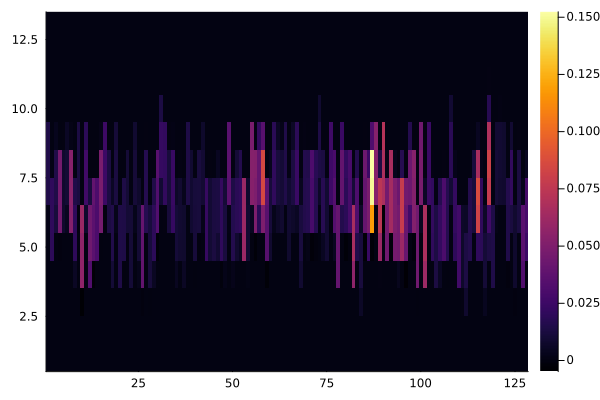

In [40]:
heatmap(xi.current.current_fn(0.4))

In [41]:
xli = ylocal_to_current(xl, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0))

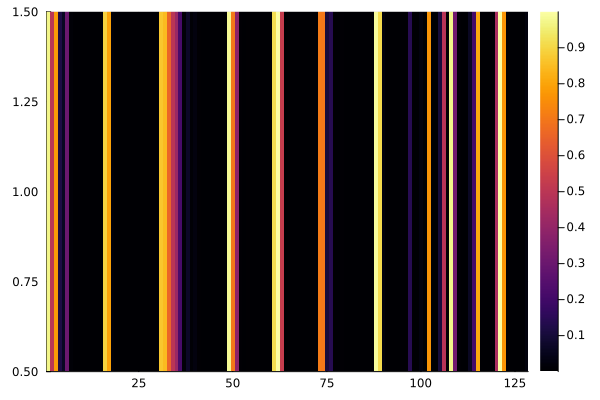

In [42]:
heatmap(xli.current.current_fn(0.7))

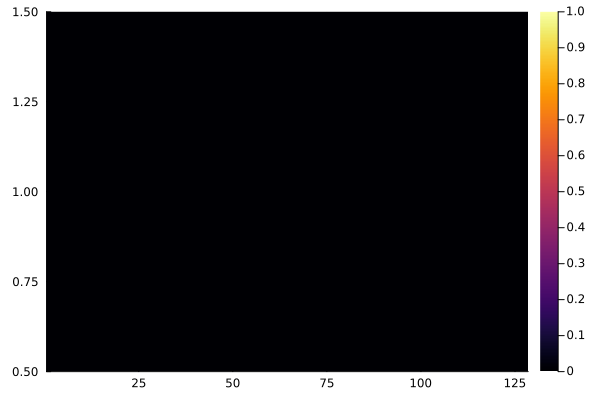

In [43]:
heatmap(xli.current.current_fn(1.7))

In [44]:
xli

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0))

In [45]:
xli.t_span

(0.0, 20.0)

In [46]:
xi.current.shape

(13, 128)

In [47]:
xxli = cat_currents(xi, xli, dim=1)

CurrentCall(LocalCurrent(var"#32#34"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#current_fn#28"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0

In [48]:
xxli.current.shape

(14, 128)

In [49]:
xxli.current.offset

0.0

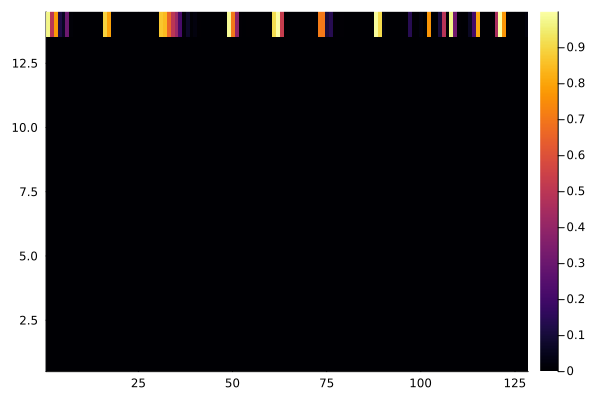

In [50]:
heatmap(xxli.current.current_fn(0.7))

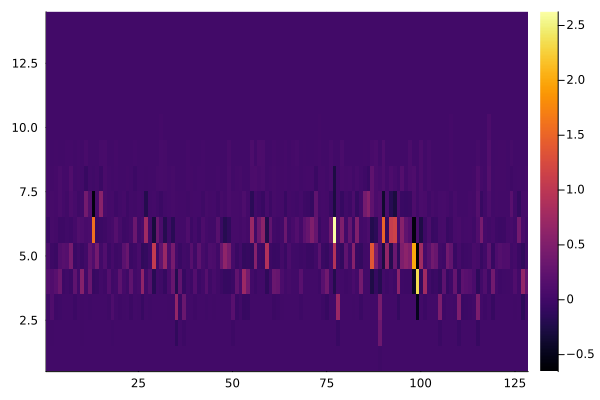

In [51]:
heatmap(xxli.current.current_fn(0.3))

In [52]:
stats_sample = [vec(xxli.current.current_fn(t)) for t in 0.0:0.05:1.25] |> stack;

In [53]:
extrema(stats_sample)

(-0.9585047619047619, 4.74392)

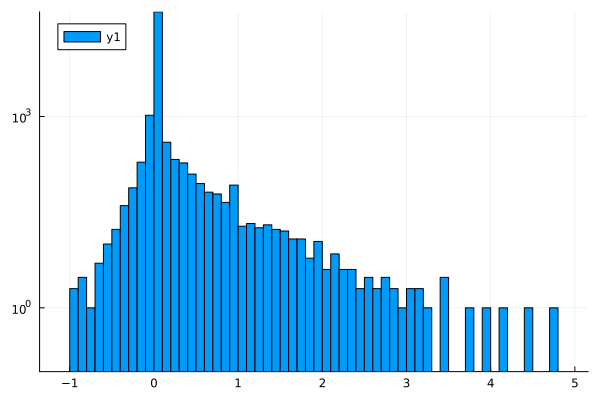

In [54]:
histogram(vec(stats_sample), yscale=:log10)

In [57]:
xxli.t_span

(0.0, 20.0)

In [59]:
function process_sample(x; spk_args::SpikingArgs, tspan::Tuple, kwargs...)
    charge, ylocal = x
    x1 = charge_to_current(charge, spk_args=spk_args, tspan=tspan)
    x2 = ylocal_to_current(ylocal, spk_args=spk_args, tspan=tspan)
    xf = cat_currents(x1, x2, dim=1)
    
    return xf
end

process_sample (generic function with 1 method)

In [60]:
x1 = process_sample((x, xl), spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(var"#32#34"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#current_fn#28"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0

In [61]:
ode_model = Chain(PhasorResonant(n_in, spk_args),
                x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0, threshold=false),
                PhasorDenseF32(n_in => 128),
                PhasorDenseF32(128 => 3)
                )

Chain(
    layer_1 = PhasorResonant(14, PhasorNetworks.var"#170#173"{Int64}(14), PhasorNetworks.var"#171#174"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), PhasorNetworks.var"#172#175"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), true),  # 198 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#50#51"()),
    layer_3 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_4 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_636 parameters,
          #        plus 0 states.

In [62]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[1.0 -0.20685676 … -0.15308303 0.03986245; -0.23205957 1.0 … -0.16681373 -0.7870263; … ; 0.27921075 -0.12964822 … 1.0 0.16653901; -0.068519555 -0.22273916 … 0.018576955 1.0], leakage = [-0.1], t_period = [1.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.15166335 -0.13593228 … -0.023270732 0.108509675; -0.13994952 -0.06210387 … 0.036426414 0.11977129; … ; -0.005094033 -0.011508355 … -0.028394422 0.02365087; 0.038379274 -0.09693792 … -0.0014038611 0.008463978], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_4 = (weight = Float32[0.07865547 0.1592249 … 0.061088853 -0.16829833; -0.055124063 -0.0947963 … 0.120956585 -0.029126784; 0.014567931 0.07080011 … -0.009549992 0.13062628], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 

In [63]:
y_naive, _ = ode_model(x1, ps, st);

In [64]:
y_naive

3×128 Matrix{Float64}:
  0.0373939   0.0821019   0.0608204   0.0917491  …   0.13749       0.0698592
  0.322765   -0.0225746   0.293814    0.217275      -0.13221       0.279808
 -0.262922   -0.282387   -0.321507   -0.318326       0.000295422  -0.128511

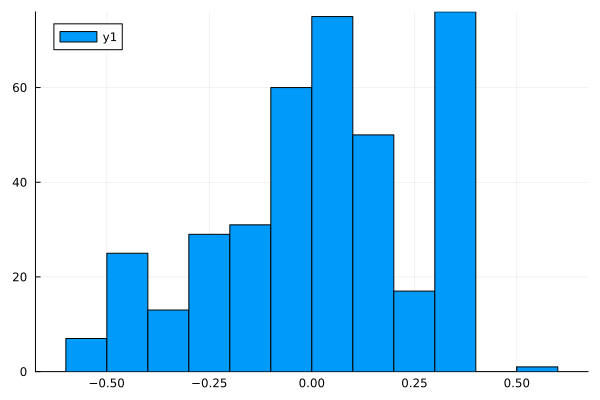

In [65]:
histogram(y_naive |> vec)

In [66]:
psf = ComponentArray(ps)

ComponentVector{Float64}(layer_1 = (weight = [1.0 -0.20685675740242004 … -0.15308302640914917 0.03986245021224022; -0.2320595681667328 1.0 … -0.16681373119354248 -0.7870262861251831; … ; 0.27921074628829956 -0.12964822351932526 … 1.0 0.1665390133857727; -0.06851955503225327 -0.22273916006088257 … 0.018576955422759056 1.0], leakage = [-0.1], t_period = [1.0]), layer_2 = Float64[], layer_3 = (weight = [-0.15166334807872772 -0.13593228161334991 … -0.023270731791853905 0.10850967466831207; -0.1399495154619217 -0.06210387125611305 … 0.03642641380429268 0.11977128684520721; … ; -0.005094033200293779 -0.011508354917168617 … -0.028394421562552452 0.023650869727134705; 0.03837927430868149 -0.09693791717290878 … -0.001403861097060144 0.008463977836072445], bias_real = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_4 

In [67]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [68]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [119]:
function loss(x, y, model, ps, st, threshold)
    y_pred, st = model(x, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 2 methods)

In [120]:
loss(x1, y, ode_model, psf, st, 0.2)

(0.49160922233974297, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [121]:
v, gs = withgradient(p -> loss(x1, y, ode_model, p, st, 0.2, spk_args), psf)

(val = (0.49160922233974297, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())), grad = ((layer_1 = (weight = [-2.4726104233800654e-6 -8.612595520296789e-5 … 0.0 -0.11922371884081868; 2.1819027223549247e-6 -4.591352788749621e-5 … 0.0 -0.0020524886534000024; … ; -1.1280827777529092e-5 0.0014703760618113976 … 0.0 -0.007411403090702524; -5.908496859486317e-7 -1.5663822210284366e-5 … 0.0 0.0035683804171499347], leakage = [-0.01041522302322587], t_period = [13.920497027256452]), layer_2 = Float64[], layer_3 = (weight = [-0.0032311334492622326 0.00037447061856015916 … -0.001675535510748939 -0.0008086296646390127; -0.005083903255779071 0.01731673173855959 … -0.018567441795170576 -0.01585229903671689; … ; 0.005158676048762488 -0.001554433234725139 … 0.002710639262146634 0.0003005253837693244; 0.00913254304176237 0.03869835129027706 … -0.032510688416927974 -0.02918184316402932], bias_real = [-0.0012721132293424993, -3.085136594687025e-5, -0.0004634

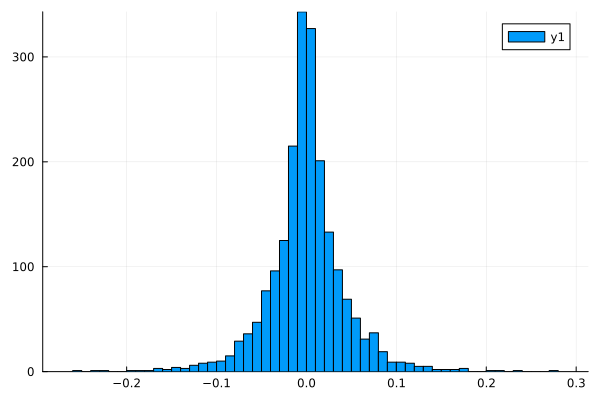

In [72]:
histogram(vec(gs[1].layer_3))

In [73]:
function train(model, ps, st, train_loader; threshold::Real = 0.2, id::Int=1, verbose::Bool = true, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, xl, y) in train_loader
            x = process_sample((x, xl), spk_args=spk_args, tspan=tspan)
            (loss_val, st), gs = withgradient(p -> loss(x, y, model, p, st, threshold, spk_args), ps)
            append!(losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            if verbose
                println(reduce(*, ("Epoch ", string(epoch), ", loss ", string(loss_val))))
            end
        end
        #append!(losses, mean(epoch_losses))
        #println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 1 method)

In [74]:
loss_history, pst, stt = train(ode_model, psf, st, train_loader, threshold = 0.2, epochs = 1)

Epoch 1

[ Info: Constructing model and starting training


Epoch 1, loss 0.49160922233974297
Epoch 1, loss 0.44170197937086586
Epoch 1, loss 0.42691304089110754
Epoch 1, loss 0.3880606774078425
Epoch 1, loss 0.33682270414666404
Epoch 1, loss 0.325473680996081
Epoch 1, loss 0.3025955581072704
Epoch 1, loss 0.2922259655307814
Epoch 1, loss 0.2880346051363431
Epoch 1, loss 0.3146790759445506
Epoch 1, loss 0.2709141554044872
Epoch 1, loss 0.25667004278276984
Epoch 1, loss 0.3090731693856579
Epoch 1, loss 0.2746959375321882
Epoch 1, loss 0.24878017069585917
Epoch 1, loss 0.26243304654261795
Epoch 1, loss 0.2570088400515262
Epoch 1, loss 0.24719709091458383
Epoch 1, loss 0.24203184503236544
Epoch 1, loss 0.24294553640709568
Epoch 1, loss 0.25018300302306123
Epoch 1, loss 0.23859564046730852
Epoch 1, loss 0.23438977862146695
Epoch 1, loss 0.23572386433905715
Epoch 1, loss 0.2543730464666902
Epoch 1, loss 0.2410163079408114
Epoch 1, loss 0.22613682954073866
Epoch 1, loss 0.24175563459563743
Epoch 1, loss 0.23255473037874705
Epoch 1, loss 0.23277173100

(Any[0.49160922233974297, 0.44170197937086586, 0.42691304089110754, 0.3880606774078425, 0.33682270414666404, 0.325473680996081, 0.3025955581072704, 0.2922259655307814, 0.2880346051363431, 0.3146790759445506  …  0.21523679889575975, 0.18801809438709147, 0.21781692948384632, 0.19363921959178315, 0.2024410704883694, 0.20331360694645934, 0.22369025133116308, 0.20766036281376837, 0.2009965272118482, 0.20835959543323362], (layer_1 = (weight = [0.9701640434260721 -0.14793001735619948 … -0.15656290139698398 0.04964678073249882; -0.2104222984044798 0.9960908863754208 … -0.16485033681056255 -0.8081213398809628; … ; 0.2404108220294763 -0.1366971495764006 … 0.9821684951684739 0.1822169120178839; -0.09698952037153505 -0.23097218026714925 … 0.0022593001666027087 0.9998154066613237], leakage = [-0.10779340208706738], t_period = [1.0019651171018287]), layer_2 = Float64[], layer_3 = (weight = [-0.1193630331120803 -0.11978287730696921 … 0.003430151038328431 0.09560300169063722; -0.11037032282954239 -0.0

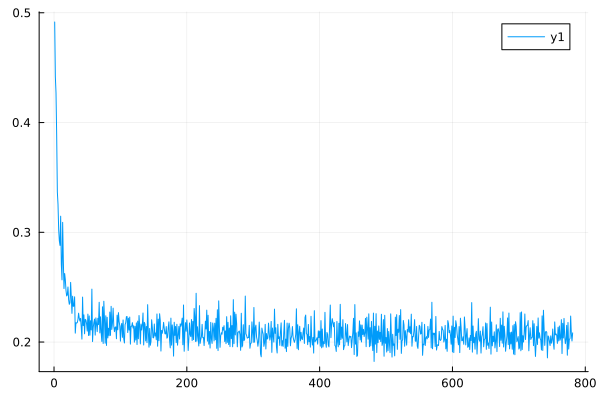

In [75]:
plot(loss_history)

In [76]:
#loss_history2, pst2, stt2 = train(ode_model, pst, st, train_loader, threshold = 0.2, epochs = 10)

In [77]:
#plot(append!(loss_history, loss_history2))

In [78]:
loss_history[end]

0.20835959543323362

In [79]:
#load params

In [80]:
#res = load("trained_nns/ode_id_43_epoch_100.jld2")

In [81]:
# pst = res["params"]
# stt = res["state"]

In [82]:
pst2 = pst

ComponentVector{Float64}(layer_1 = (weight = [0.9701640434260721 -0.14793001735619948 … -0.15656290139698398 0.04964678073249882; -0.2104222984044798 0.9960908863754208 … -0.16485033681056255 -0.8081213398809628; … ; 0.2404108220294763 -0.1366971495764006 … 0.9821684951684739 0.1822169120178839; -0.09698952037153505 -0.23097218026714925 … 0.0022593001666027087 0.9998154066613237], leakage = [-0.10779340208706738], t_period = [1.0019651171018287]), layer_2 = Float64[], layer_3 = (weight = [-0.1193630331120803 -0.11978287730696921 … 0.003430151038328431 0.09560300169063722; -0.11037032282954239 -0.05862063469486727 … 0.05311403103191138 0.1140447329209004; … ; -0.02635101779766565 -0.01849457560297395 … -0.06311380181745609 0.05542998453289713; 0.022159222779968527 -0.10182038146922633 … 0.008843208541477143 0.008559096345228667], bias_real = [1.01661881008854, 1.0018735971279096, 0.9909040007405189, 1.0081944480164677, 1.0031720260121308, 1.0080843315333998, 1.0050140838598671, 0.998638

In [83]:
loss(x1, y, ode_model, pst2, stt, 0.2, spk_args)

(0.19992389637635444, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [84]:
yt, _ = ode_model(x1, pst2, stt)

([0.014705453489702505 0.01768396299818359 … 0.02351568226289158 0.011047338466514671; 0.27082027738177405 0.27996621439646985 … 0.23483013741692996 0.23346785061823722; 0.1863004437700782 0.21884139844744907 … 0.24410142075739266 0.25527718256666293], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

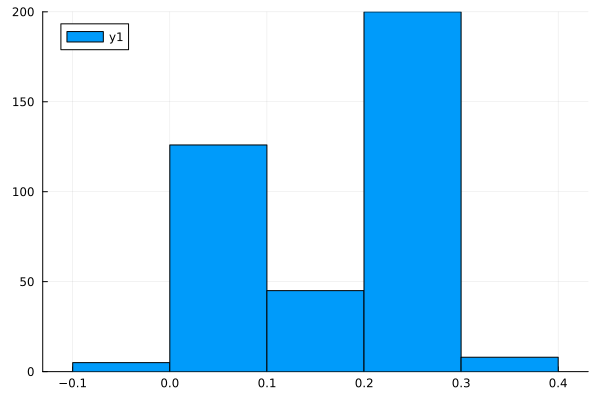

In [85]:
histogram(yt |> vec)

In [86]:
using JLD2

In [87]:
#save_object("trained_resonant.jld2", Dict("params" => pst2, "state" => stt))

# Calculate the Test Loss

In [88]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [89]:
function accuracy(x, xl, y, model_call::Function, threshold::Real)
    y_truth = get_truth(y, threshold)
    x = process_sample((x, xl), spk_args=spk_args, tspan=tspan)
    y_pred = model_call(x)
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 2 methods)

In [90]:
accuracy(xts, xlts, yts, x -> ode_model(x, pst2, stt)[1], 0.2)

70

In [91]:
xtest = process_sample((q_test[:,:,:,1:10000], ylocal_test[1:10000]), spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(var"#32#34"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, false, [0.3987849230769231 0.4931546 … 0.6012373846153847 0.6152203076923077]), (1, 10000), 0.0), LocalCurrent(var"#current_fn#28"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0

In [92]:
@time yth = ode_model(xtest, pst2, stt)[1]

LoadError: InterruptException:

In [93]:
function accuracy_compare(y_pred, y, threshold::Real)
    y_labels = predict_quadrature(y_pred) .- 1
    y_truth = get_truth(y, threshold)
    right = sum(y_truth .== y_labels)
    return right
end

accuracy_compare (generic function with 1 method)

In [94]:
accuracy_compare(yth, pt_test[1:10000], 0.2)

LoadError: UndefVarError: `yth` not defined

In [95]:
pr_layer = Chain(PhasorResonant(n_in, spk_args, true),)

PhasorResonant(14, PhasorNetworks.var"#170#173"{Int64}(14), PhasorNetworks.var"#171#174"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), PhasorNetworks.var"#172#175"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), true)  # 198 parameters

In [96]:
pst2.layer_1.leakage

1-element view(::Vector{Float64}, 197:197) with eltype Float64:
 -0.10779340208706738

In [97]:
pst2.layer_1.t_period

1-element view(::Vector{Float64}, 198:198) with eltype Float64:
 1.0019651171018287

In [98]:
spk_args_t = SpikingArgs(t_period = pst2.layer_1.t_period[1], leakage = pst2.layer_1.leakage[1])

Neuron parameters: Period 1.0019651171018287 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [99]:
pr_ps = pst2.layer_1

ComponentVector{Float64,SubArray...}(weight = [0.9701640434260721 -0.14793001735619948 … -0.15656290139698398 0.04964678073249882; -0.2104222984044798 0.9960908863754208 … -0.16485033681056255 -0.8081213398809628; … ; 0.2404108220294763 -0.1366971495764006 … 0.9821684951684739 0.1822169120178839; -0.09698952037153505 -0.23097218026714925 … 0.0022593001666027087 0.9998154066613237], leakage = [-0.10779340208706738], t_period = [1.0019651171018287])

In [100]:
pr_st = st.layer_1

NamedTuple()

In [101]:
pr_sol1 = pr_layer(x1, pr_ps, pr_st)[1];

In [102]:
pr_u1 = solution_to_potential(pr_sol1);

In [103]:
pr_p1 = solution_to_phase(pr_sol1, spk_args=spk_args_t, final_t=false);

In [104]:
size(pr_p1)

(14, 128, 2001)

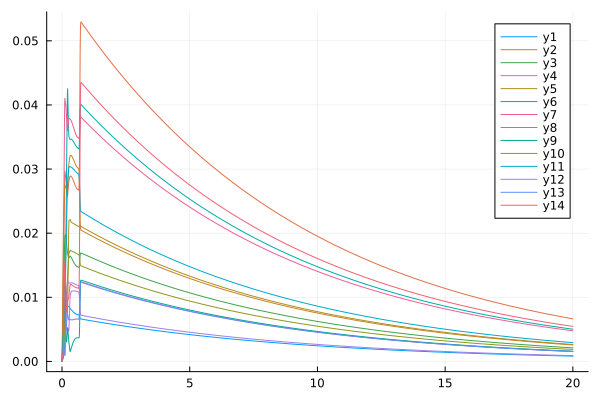

In [105]:
plot(pr_sol1.t, abs.(pr_u1[:,1,:]'))

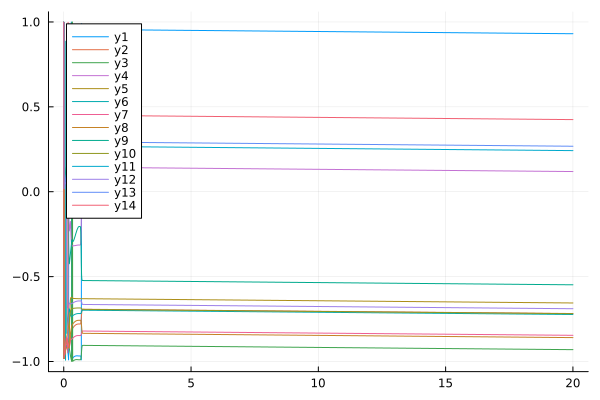

In [106]:
plot(pr_sol1.t, pr_p1[:,1,:]')

In [83]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [84]:
using LinearAlgebra: diag

In [85]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [86]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 1.1494252873563219e-6
 0.0006
 0.0016
 0.0058
 0.0229
 0.0779
 0.1993
 0.3944
 0.608
 0.7589
 0.8524
 0.9018
 0.9244
 0.9892
 0.9944
 0.9966
 0.9985
 0.9996
 0.9998
 1.0

In [87]:
roc_xs = 0.0:0.01:1.0

0.0:0.01:1.0

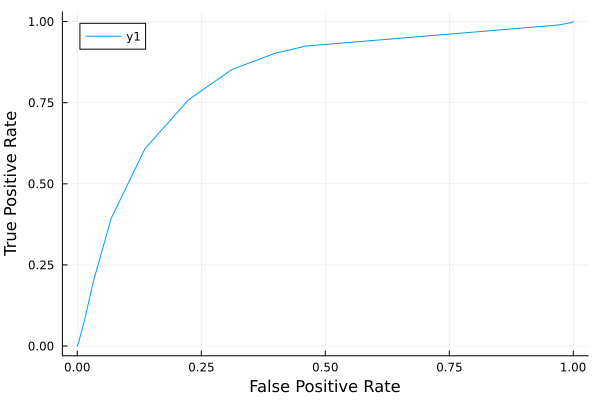

In [88]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

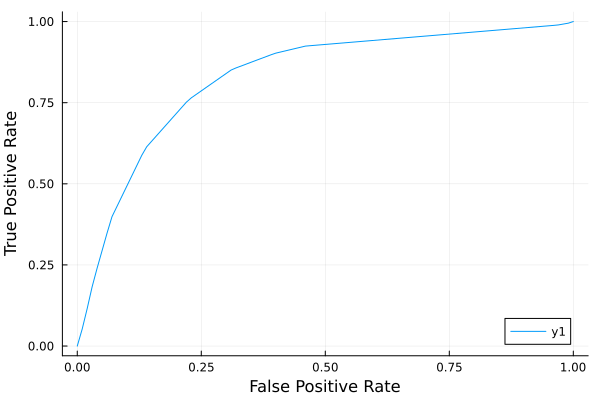

In [89]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [90]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8283466398683034, 1.2072376617215986e-8)

# Make a spiking version

In [107]:
spk_ode_model = Chain(PhasorResonant(n_in, spk_args_t, false),
                x -> x,
                PhasorDenseF32(n_in => 128),
                PhasorDenseF32(128 => 3)
                )

Chain(
    layer_1 = PhasorResonant(14, PhasorNetworks.var"#170#173"{Int64}(14), PhasorNetworks.var"#171#174"{SpikingArgs}(Neuron parameters: Period 1.0019651171018287 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), PhasorNetworks.var"#172#175"{SpikingArgs}(Neuron parameters: Period 1.0019651171018287 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
), false),  # 198 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#59#60"()),
    layer_3 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_4 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_636 parameters,
          #        plus 0 states.

In [108]:
yspk, _ = spk_ode_model(xxli, pst2, stt)

(SpikingCall(Spike Train: (3, 128) with 7680 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [109]:
yspk_p = train_to_phase(yspk);

In [110]:
y_p, _ = ode_model(xxli, pst2, stt);

In [111]:
yspk_p |> size

(20, 3, 128)

In [112]:
y_p |> size

(3, 128)

In [113]:
cycle_correlation( y_p, yspk_p)

20-element Vector{Float64}:
  0.6508459909205898
  0.6198870899456324
  0.8520555329252252
  0.8773861794233853
  0.8837722151449567
  0.8875176181231027
  0.8905753102731205
  0.8931687015349462
  0.8953668556565186
  0.8972260278532513
  0.898798113788732
  0.9001290807021238
  0.9012639892220505
  0.9022234979093839
  0.9030299831091704
  0.9036990450986564
  0.9042515935084074
  0.9110547741579663
  0.9173096681540129
 -0.3032499940835428

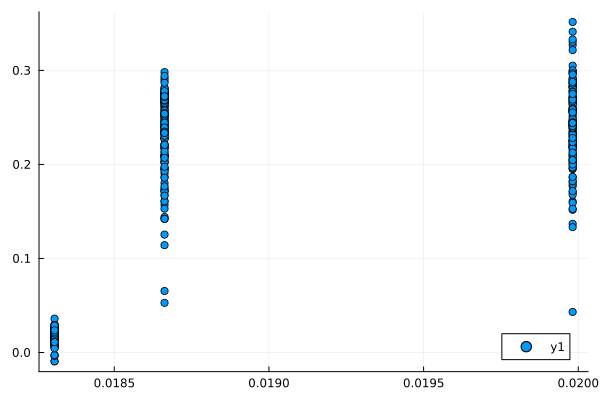

In [114]:
scatter(yspk_p[1,:,:] |> vec, y_p |> vec)

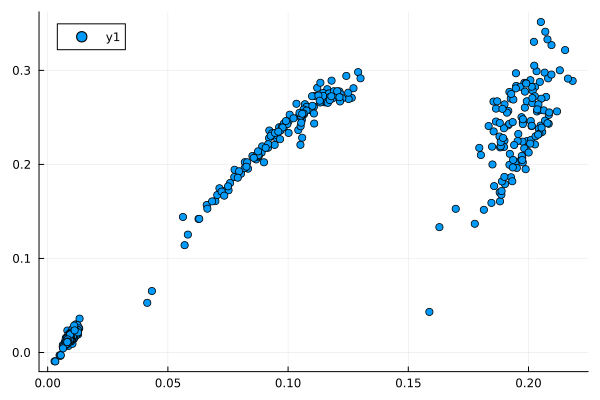

In [115]:
scatter(yspk_p[3,:,:] |> vec, y_p |> vec)

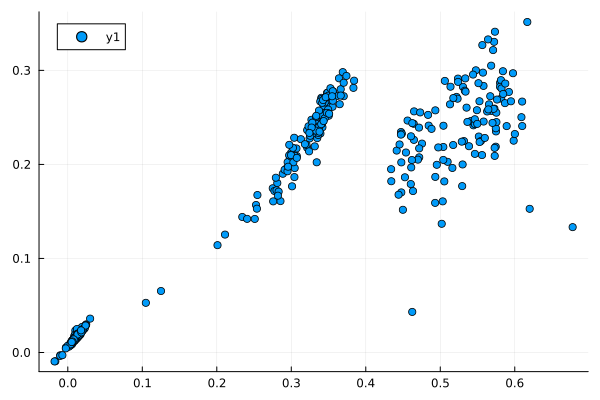

In [116]:
scatter(yspk_p[end-5,:,:] |> vec, y_p |> vec)

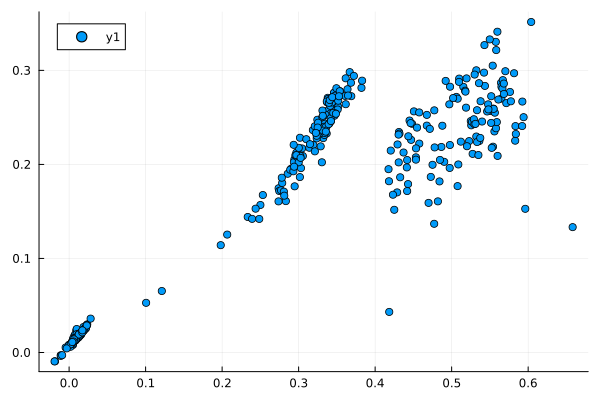

In [117]:
scatter(yspk_p[end-2,:,:] |> vec, y_p |> vec)

In [118]:
[accuracy_compare(aa, y, 0.2) for aa in eachslice(yspk_p, dims=1)]

20-element Vector{Int64}:
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 71
 72
 72
 73
 71
 71
 51

In [114]:
@time yth_spk = spk_ode_model(xtest, pst2, stt)[1]

1036.949312 seconds (892.70 k allocations: 807.616 GiB, 87.20% gc time)


SpikingCall(Spike Train: (3, 10000) with 599984 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0))

In [117]:
yth_spk_p = train_to_phase(yth_spk);

In [118]:
[accuracy_compare(aa, pt_test[1:10000], 0.2) for aa in eachslice(yth_spk_p, dims=1)]

20-element Vector{Int64}:
 4656
 4656
 4656
 4656
 5060
 5306
 5286
 5300
 5296
 5287
 5260
 5255
 5239
 5231
 5207
 5171
 5125
 5058
 5102
  603

In [119]:
roc_spk = tpr_fpr(yth_spk_p[6,:,:], pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [120]:
roc_fn_spk = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...);

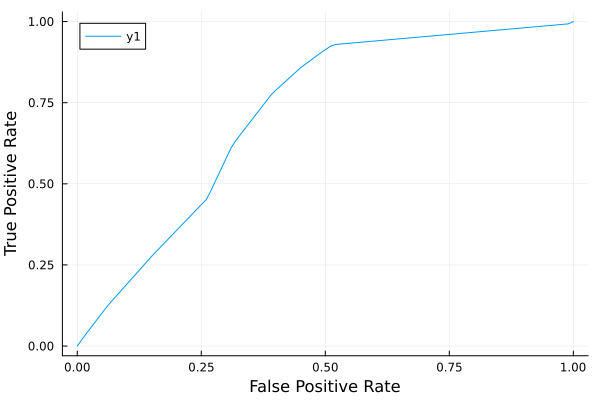

In [121]:
plot(roc_xs, roc_fn_spk.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [122]:
auc, _ = quadgk(roc_fn_spk, 0.0, 1.0)

(0.7169565701713261, 9.473473096791398e-9)